# Changes from previous version

1.) Increased the amount of data I'm pulling to roughly a 17 year period from 2000-01-01 to 2017-10-16.

2.) Providing more Visualization of the rare events and  distribution of the volatility and other features

3.) Added new features from Quandl such as the vix,unemployment, fed funds rate, etc.


### Addressed previous modeling concerns


4.) Was actually modeling the problem strangely before, I was representing the problem in a way that I didn't thoroughly agree with. In short I was taking the the change in return and comparing it to volatility which is sort of a strange way to think about the problem, comparing day over day vol to long term vol. I've reframed the problem to be strictly in terms of returns. It's now $$\mu + 3.5 \sigma < r \ or \ \mu - 3.5\sigma > r$$ Where $\mu$ and $\sigma$ are rolling mean and stdev respectively and $R$ is the return of the day. THis gives us 20 events in a 17 year period with 5 of them taking place in 2008. All together,  that's roughly a 99.95% negative class to .05% positive class imbalance

5.) Reworked how we scale data. Since it's a timeseries we shouldn't be looking ahead therefore we can't use Standard Scaler from sklearn. Created a custom scaler for this. It scales by normalizing using the rolling standard deviation and mean up to that point. This prevents information leakage

6.) Reworked how we shuffle data, (we don't now) Therefore there is no information leakage from the future

7.) Synthetic data has been removed as Ceena suggested we take a second look to confirm if it was statistically sound to use a GMM.  If we want to use synthetic data I think it'll be okay to use bootstrapped data (since that has some statistical precedent) to augment the training set but I don't for now just to be as careful as possible. The only "synthetic samples" in the training set are coming from the SMOTEENN oversampler/undersampler

8.) Extended the Deep Neural Network framework to include maxout layers

### Performance


The model is starting to show it's predictive power, even though it doesn't pick up exactly on the events described it is able to model certain spikes in the level of the index. On the validation and test sets the signal turns "on" before and after an event actually happens. It even picks up on patterns that look like they should be events such as spikes in the VIX. Please see the graphs and numerics in the Results section for details. In the pairs of 3 graphs, the first with the red lines are the labels or actual events, the blue lines are predicted events, and the green lines are the intersection of the two sets

### Next steps

I tired to incorporate some futures data into our analysis, there exists some correlation between the gold and crude oil commodity futures and the sp500, I've read about such studies before. However using futures presents a problem of how to make them continuous contracts and how to get that data for free. Quandl has free continous contracts going back to 2005 but to go back further you'd have to pay.

I tried my best to make this as robust as possible so there's no information leakage from the future into the past. However I'd appreciate it if someone went over my modeling process in detail to make sure I didn't miss anything. I'd like to try using synthetic data assuming we can do it properly, like I mentioned before we could probably just bootstrap.

We should also experiment with different defintions of a market event as my current definition of 3.5 times the rolling sigma seems a bit arbitrary but it has nice properties. Such as having a few number of events except during the crisis but still having enough events that our validation and test sets actually have something to detect.



In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
@author: Michael Di Amore
"""

%matplotlib inline
import tensorflow as tf
import Query as query
import quandl 
import numpy as np
# np.random.seed(12345) # Set seed

import pandas as pd
from sklearn.mixture import GaussianMixture
from imblearn.combine import SMOTEENN 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.utils import resample
from keras.layers import Dense,BatchNormalization,Input,Convolution1D,GRU,Dropout,TimeDistributedDense
from keras.models import Model
import keras
import pdb
from sklearn.metrics import accuracy_score,f1_score,roc_auc_score,recall_score,precision_score
import warnings
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10, 6)

Using TensorFlow backend.


# Load Data GDELT

In [2]:
####
#  Load Data. If you don't want to / can't run the query.
# Basically this is all data from 2007-01-01 to 2017-10-06
load_data = True
if load_data == True:
    print ('Loading Data...')
    df_2001 = pd.read_csv('Gdelt_events_20000101_20061231.csv')
    df_2001 = df_2001.set_index('sqldate',drop=True).sort_index()
    df_early = pd.read_csv('Gdelt_events_20070101_20131231.csv')
    df_early = df_early.set_index('sqldate',drop=True).sort_index()
    df_2014_01 = pd.read_csv('Gdelt_events_20140101_20140531.csv')
    df_2014_01  = df_2014_01 .set_index('sqldate',drop=True).sort_index()
    
    df_2014_02 = pd.read_csv('Gdelt_events_20140601_20141231.csv')
    df_2014_02  = df_2014_02 .set_index('sqldate',drop=True).sort_index()
    
    df1 = pd.read_csv('Gdelt_events_20150101_20151231.csv')
    df1 = df1.set_index('sqldate',drop=True).sort_index()
    df2 = pd.read_csv('Gdelt_events_20160101_20171006.csv')
    df2 = df2.set_index('sqldate',drop=True).sort_index()
    gdelt_df = pd.concat([df_2001,df_early,df_2014_01,df_2014_02,df1,df2])
    
    del df_2001,df_early,df_2014_01,df_2014_02,df1,df2
    
####
# Set Params
lookback_window = int(np.round(252/2))
daily_security_vol_target = .15/np.sqrt(252) #.15 is the 10 year SPY volalility found here
#http://performance.morningstar.com/funds/etf/ratings-risk.action?t=SPY&region=usa&culture=en-US
####

proj_id = 'capstone-v0'
start_date = '2000-01-01'
end_date = '2017-10-06'
ticker = '^GSPC'
my_query = query.query_tool(proj_id,start_date,end_date,ticker)
sql_query = """
            SELECT Actor1Name, GoldsteinScale,NumMentions,sourceurl,
            sqldate, avgtone, numarticles, numsources,  
            FROM [gdelt-bq:full.events] 
            WHERE sqldate > 20010101 and sqldate <= 20061231  and 
            Actor1Code like '%BUS%'and
            Actor1Geo_CountryCode like "%US%"
            """
if load_data == False:
    print ('Querying Gdelt...')
    my_query.query_gdelt(sql_query)
    my_query.gdelt_df = my_query.gdelt_df.set_index('sqldate',drop=True).sort_index()
    df = my_query.gdelt_df.copy(True)

#Creating Labels. i.e. if change in spx_return is x standard deviations
security_prices = my_query.query_yahoo()
security_return = np.log(security_prices['Adj Close']).diff() #log Return
security_vol = security_return.rolling(window=lookback_window).std().dropna()
security_mean = security_return.rolling(window=lookback_window).mean().dropna()
security_vol.name = 'Volatility'
security_return = security_return.loc[security_vol.index] #First entry is NAN because of return
# day_over_day_diff = np.abs(security_return.diff())#can subtract because of log returns
# event_idx = [(np.abs(security_mean)+(security_vol * 3.5)) < np.abs(security_return)]
event_idx = [((security_mean + security_vol * 3.5) < security_return) | ((security_mean - security_vol *3.5) > security_return) ]
event_idx = np.array(event_idx).astype(int).flatten()
event_idx = pd.Series(event_idx,index=security_return.index)
print ('Data Loaded')

Loading Data...
Data Loaded


# Load Data Quandl

In [3]:
api_key =  #INSERT YOUR QUANDL API KEY HERE 
wti_co = my_query.query_quandl("FRED/DCOILWTICO",api_key)
unemploy = my_query.query_quandl("FRED/UNEMPLOY",api_key)
m1v = my_query.query_quandl("FRED/M1V",api_key)
m2v = my_query.query_quandl("FRED/M2V",api_key)
stressindex = my_query.query_quandl("FRED/STLFSI", api_key)
dff = my_query.query_quandl("FRED/DFF",api_key)
my_query.set_ticker('^VIX')
vix = my_query.query_yahoo()
vix = vix['Adj Close']
vix.name = 'VIX'
print ('Quandl Loaded')

#Use GLD as proxy for gold. Better to use the futures but don't have good continuous contracts
# my_query.set_ticker('GLD')
# gld = my_query.query_yahoo()
# gld = gld['Adj Close']

#Use Continuous Future of Front month gold contract as gold
# gold = my_query.query_quandl("SCF/CME_GC1_OR",api_key)
# gold = gold['Settle']
# #Use Continuous Future of front month  crude as oil
# oil = my_query.query_quandl("SCF/ICE_B1_OB",api_key)
# oil = oil['Settle']

Quandl Loaded


In [4]:
quandl_others = pd.concat([wti_co,unemploy,m1v,m2v,stressindex,vix,dff],axis=1)
quandl_others.columns = ['wit_co','unemploy','m1v','m2v','slsi','vix','dff']
quandl_others.ffill(inplace=True)
quandl_others.fillna(0,inplace=True)

# Visualizations

### Distributions of Target

Lets start by examining the dates of the "market events" and the distributions of volatility

In [37]:
event_idx.loc['2008-01-01':'2009-12-31'].sum()/event_idx.sum()

5

Number of events over time frame 20
Approximate number of years in time frame 17.238095238095237


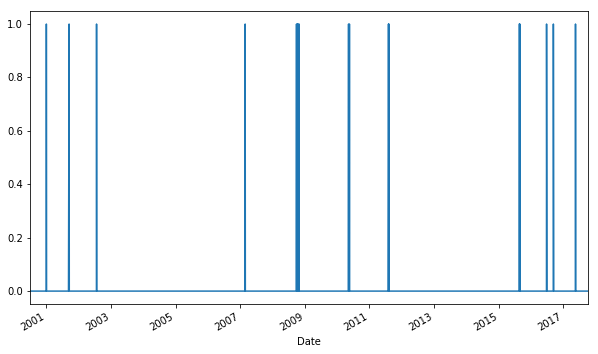

In [6]:
print ('Number of events over time frame {}'.format(event_idx.sum()))
print('Approximate number of years in time frame {}'.format(len(event_idx)/252))
z = pd.Series(event_idx)
z.name = 'Events'
z.plot()


In [7]:
event_idx.sum()/len(event_idx)

0.004604051565377533

As we can see the number of volatility events takes place mostly between 2008-2009 as expected

Now lets take a look at a price chart, this is helpful for us to understand the drift of the security, and maybe if anyone has any insight we could switch gears to predicting returns/prices instead of volatility. However, the literature normally suggest that volatilty is easier to predict. But is still debatable 

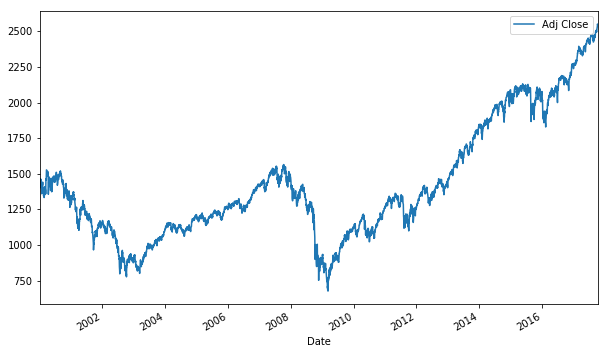

In [8]:
plt.figure()
security_prices['Adj Close'].plot()
plt.legend()


Here we have the fed funds rate over time

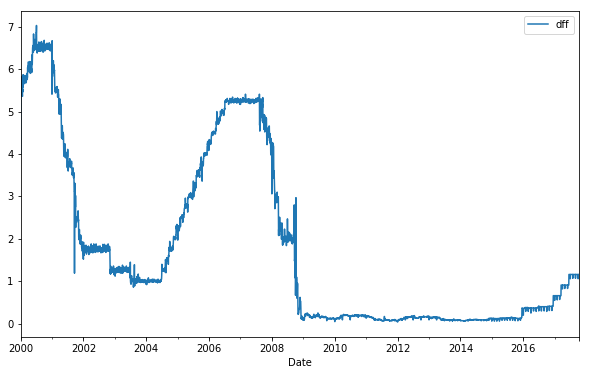

In [9]:
plt.figure()
quandl_others['dff'].plot()
plt.legend()

A plot of the VIX, as you can see during 2009 the vix reached record highs and is now in record lows

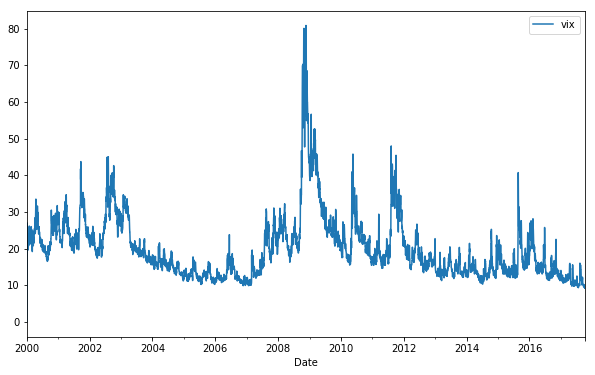

In [10]:
plt.figure()
quandl_others['vix'].plot()
plt.legend()

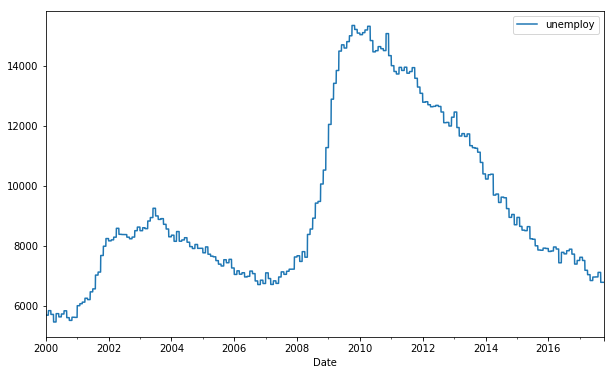

In [11]:
plt.figure()
quandl_others['unemploy'].plot()
plt.legend()

How has the volatility evolved over time? Note this is the 252 day moving average, or a trading year. Notice how volatility  skyrockets during the crisis of 2008-2009 and is now at all significant lows. We can think of market volatility as determing the regime we are currently in, in the market. To make it more concrete think of volatility levels as determining the state from which all market returns are generated

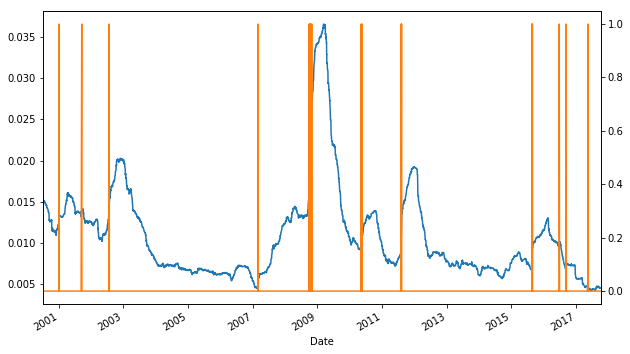

In [12]:
plt.figure()
security_vol.plot()
z.plot(secondary_y=True)


What is the distribution of volatility over this period? As you can see the histogram doesn't appear to look like any familiar family of distributions. The kde smoothed estimate looks sort of bimodal with fat tails

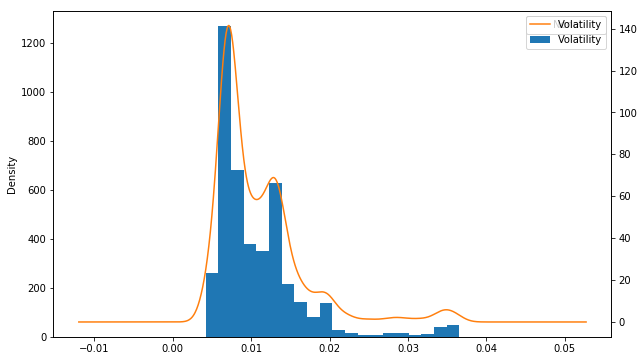

In [13]:
plt.figure()
security_vol.plot.hist(bins=20)
plt.legend()
security_vol.plot.kde(secondary_y=True)
plt.legend()

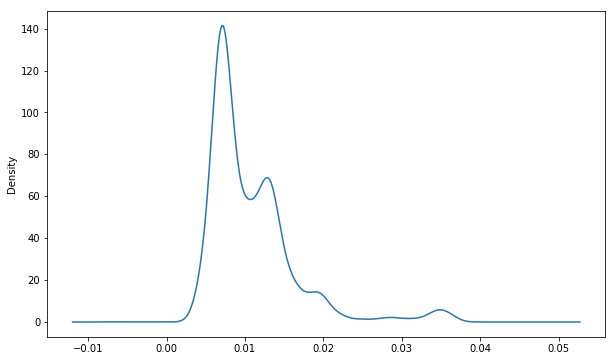

In [14]:
security_vol.plot.kde()

### Distribution of features

First let's collapse our data, i.e. groupby and find the mean. Thereby controlling for some days having more news than other days. This also puts things on daily time scales. 

In [15]:
collapsed = gdelt_df.groupby(by=gdelt_df.index).mean()


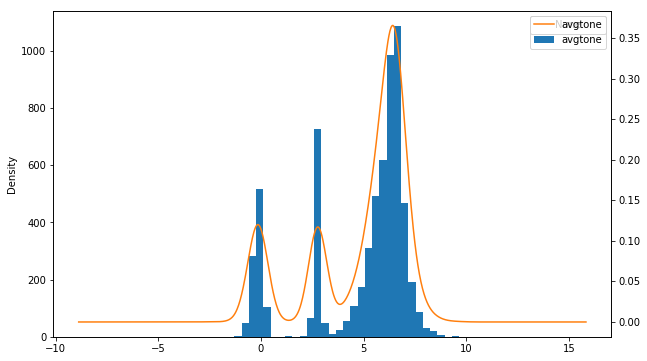

In [16]:
plt.figure()
collapsed['avgtone'].plot.hist(bins=35)
plt.legend()
collapsed['avgtone'].plot.kde(secondary_y=True)
plt.legend()

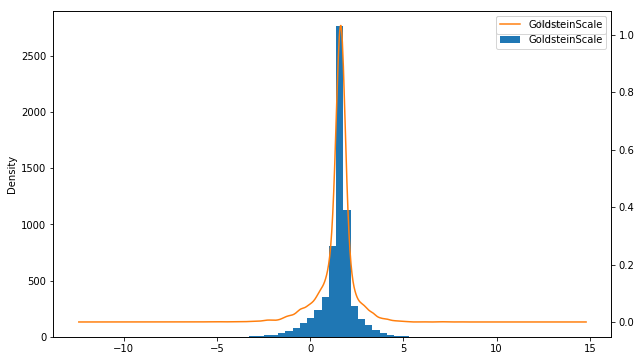

In [17]:
plt.figure()
collapsed['GoldsteinScale'].plot.hist(bins=35)
plt.legend()
collapsed['GoldsteinScale'].plot.kde(secondary_y=True)

plt.legend()

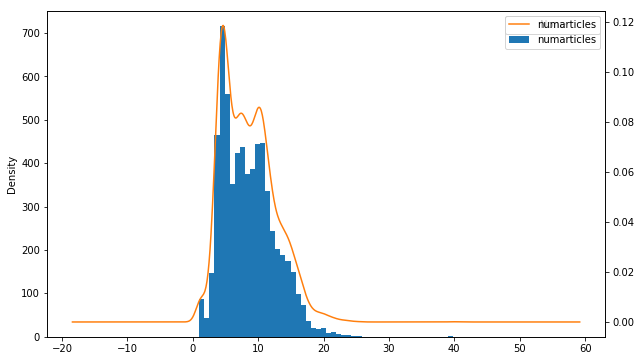

In [18]:
plt.figure()
collapsed['numarticles'].plot.hist(bins=50)
plt.legend()

collapsed['numarticles'].plot.kde(secondary_y=True)

plt.legend()

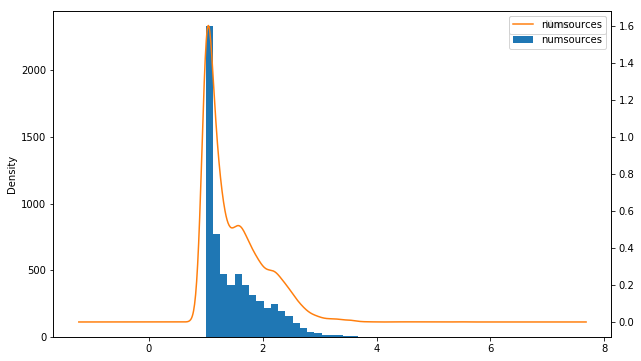

In [19]:
plt.figure()
collapsed['numsources'].plot.hist(bins=35)
plt.legend()
collapsed['numsources'].plot.kde(secondary_y=True)
plt.legend()

The Goldenstein Scale Distribution appears to be highly peaked with long tails

The Numartciles distribution looks like it is approaching a unimodal gaussian

The numsources distribution looks like it could be  some variant of the exponential 

# Modeling

In [20]:
def normalize_ts(series,lookback=lookback_window):
    rolling_mean = series.rolling(window=lookback).mean()
    rolling_std = series.rolling(window=lookback).std() + .10**3
    normalized = (series-rolling_mean)/rolling_std
    normalized = normalized.dropna()
    return(normalized)

In [21]:
#Collapse numerical data into x,y pairs by taking means
collapsed = gdelt_df.groupby(by=gdelt_df.index).mean()

#Shift data so as only to use yesterday's news for tomorrow's prediction
collapsed_shifted = collapsed.shift(1)
quandl_shifted = quandl_others.shift(1)

#Scale the data in such a way that we aren't looking forward into the feature
print ('Scaling using custom scaler')
collapsed_shifted = collapsed_shifted.apply(normalize_ts)
quandl_shifted = quandl_shifted.apply(normalize_ts)

collapsed_shifted.index = pd.to_datetime(collapsed_shifted.index,format='%Y%m%d')
collapsed_shifted = collapsed_shifted.loc[security_vol.index].dropna()
collapsed_shifted = pd.concat([collapsed_shifted,quandl_shifted],axis=1)
event_idx = event_idx.dropna()
collapsed_shifted = collapsed_shifted.loc[event_idx.index]

Scaling using custom scaler


In [22]:
print ('Creating train test split...')
X_train,X_test,Y_train,Y_test = train_test_split(collapsed_shifted,event_idx,stratify=None,test_size=.20,shuffle=False)
X_train,X_val,Y_train,Y_val = train_test_split(X_train,Y_train,test_size=.20,stratify=None,shuffle=False)


#Creating Copies of Data Frames these will be useful later for debugging
X_train_df = X_train.copy(True)
Y_train_df = Y_train.copy(True)
Y_val_df = Y_val.copy(True)

#Performing Scaling
# print ('Scaling the data...')
# X_train = np.array(X_train).reshape(-1,X_train.shape[1])
# ss = StandardScaler()
# ss = ss.fit(X_train)
# X_train = ss.fit_transform(X_train)
# X_test = ss.transform(X_test)
# X_val = ss.transform(X_val)
pca = PCA(whiten=True)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)
X_val = pca.transform(X_val)

print ('Performing Oversampling/Undersampling...')
s = SMOTEENN()
X_train,Y_train= s.fit_sample(X_train,Y_train)

print ('Proportion after smote {}'.format(sum(Y_train)/len(Y_train)))

# print ('Performing Bootstrapping...')
# print ('Creating synthetic examples via bootstrap')

# X_synth,Y_synth = resample(X_train,Y_train)
# X_train = np.concatenate((X_synth,X_train))
# Y_train = np.concatenate((Y_synth,Y_train))
# X_train = np.concatenate((X_synth,X_train))
# Y_train = np.concatenate((Y_synth,Y_train))

# X_train = X_train.reshape(-1,X_train.shape[1])


#Important!:
#Gaussian Mixture will generate a random amount of Y's from some mixture to make sure we have the proportion we want
#We have to run a loop to generate many samples
#Want to target 50% as the proportion of 1's/0's with some leeway
# desired_prop = .50
# num_hallucinated_samples = 20000
# want = desired_prop*(num_hallucinated_samples + Y_train.sum())
# lb = want - .15*num_hallucinated_samples
# ub = want + .15*num_hallucinated_samples
# total_sum = np.inf

#This creates different gaussian mixtures until we get the desired proportion
##while (total_sum < lb) or (total_sum > ub):
# X_synth,Y_synth = GaussianMixture(n_components=2,max_iter=1000,covariance_type='diag').fit(X_train,Y_train).sample(5000)
# total_sum = Y_synth.sum() + Y_train.sum()
# print (total_sum/(len(Y_synth)+len(Y_train)))
# #Combine X_synth, Y_synth with X_train Y_train
# X_train = np.concatenate((X_synth,X_train))
# Y_train = np.concatenate((Y_synth,Y_train))

X_train = X_train.reshape(-1,X_train.shape[1],1)
X_test = X_test.reshape(-1,X_test.shape[1],1)
X_val = X_val.reshape(-1,X_val.shape[1],1)
print ('Done!')

Creating train test split...
Performing Oversampling/Undersampling...
Proportion after smote 0.5051076249543962
Done!


In [23]:
print(Y_train.sum()/len(Y_train))
print(Y_val.sum()/len(Y_val))
print(Y_test.sum()/len(Y_test))
Y_train = Y_train.reshape(-1,1)

0.505107624954
0.004316546762589928
0.006904487917146145


In [24]:
from keras.regularizers import l1l2
from keras.constraints import maxnorm
from keras.layers import MaxoutDense
from keras.layers import Flatten
from keras.layers import MaxPooling1D


def simple_keras_model(original):
    original_input = Input(shape=(original.shape[1],1),name='orig')
    layer1 =  Convolution1D(512, 5, border_mode='same',activation='relu',init='he_normal',W_constraint=maxnorm(0.5))(original_input)
    layer1 = BatchNormalization()(layer1)
#     layer1 = MaxPooling1D()(layer1)
    layer1 = Dropout(.55)(layer1)
    layer2 = Convolution1D(512,5,border_mode='same',activation='relu',init='he_normal',W_constraint=maxnorm(0.5))(layer1)
    layer2 = BatchNormalization()(layer2)
#     layer2 = MaxPooling1D()(layer2)
    layer2 = Dropout(.55)(layer2)
    layer3 = Convolution1D(256,5,border_mode='same',activation='relu',init='he_normal',W_constraint=maxnorm(0.5))(layer2)
    layer3 = BatchNormalization()(layer3)
#     layer3 = MaxPooling1D()(layer3)
    layer3 = Dropout(.55)(layer3)
    layer4 = Convolution1D(128,5,border_mode='same',activation='relu',init='he_normal',W_constraint=maxnorm(0.5))(layer3)
    layer4 = BatchNormalization()(layer4)
#     layer4 = MaxPooling1D()(layer4)
    layer4 = Dropout(.55)(layer4)
    
    
    layer5 = Convolution1D(128,3,border_mode='same',activation='relu',init='he_normal')(layer4)
    layer5 = BatchNormalization()(layer5)
    layer5 = Dropout(.35)(layer5)
    

    layer6 = Convolution1D(128,3,border_mode='same',activation='relu',init='he_normal')(layer5)
    layer6 = BatchNormalization()(layer6)
    layer6 = Dropout(.35)(layer6)
    
    
    layer7 = Convolution1D(128,3,border_mode='same',activation='relu',init='he_normal')(layer6)
    layer7 = BatchNormalization()(layer7)
    layer7 = Dropout(.35)(layer7)
    
    
    layer8 = Convolution1D(128,3,border_mode='same',activation='relu',init='he_normal')(layer7)
    layer8 = BatchNormalization()(layer8)
    layer8 = Dropout(.35)(layer8)

    layer8 = Flatten()(layer8)
#     layer9 = Dense(1024,activation='relu',init='he_normal')(layer8)
#     layer10 = Dense(512,activation='relu',init='he_normal')(layer9)
#     layer11 = Dense(256,activation='relu',init='he_normal')(layer10)
#     flattened = Flatten()(layer8)
    layer9 = MaxoutDense(1024,init='he_normal')(layer8)
    layer9 = BatchNormalization()(layer9)
#     layer9 = Dropout(.35)(layer9)
    layer10 =MaxoutDense(512,init='he_normal')(layer9)
    layer10 = BatchNormalization()(layer10)
#     layer10 = Dropout(.35)(layer10)
    layer11 = MaxoutDense(128,init='he_normal')(layer10)
    layer11 = BatchNormalization()(layer11)
#     layer11 = Dropout(.35)(layer11)
    
#     flattened = Flatten()(layer8)
    output = Dense(1,activation='sigmoid')(layer11)
    

    my_model = Model([original_input], output=output)
    optimizer_adam = keras.optimizers.adam(0.001) 
    my_model.compile(loss='binary_crossentropy', optimizer=optimizer_adam, metrics=['accuracy'])

    return(my_model)

In [25]:
my_model = simple_keras_model(X_train)
my_model.fit(X_train,Y_train,nb_epoch=25,batch_size=128)

Epoch 1/25
5482/5482 [==============================] - 8s - loss: 0.2865 - acc: 0.8765     
Epoch 2/25
5482/5482 [==============================] - 2s - loss: 0.0688 - acc: 0.9777     
Epoch 3/25
5482/5482 [==============================] - 2s - loss: 0.0365 - acc: 0.9883     
Epoch 4/25
5482/5482 [==============================] - 2s - loss: 0.0253 - acc: 0.9923     
Epoch 5/25
5482/5482 [==============================] - 2s - loss: 0.0238 - acc: 0.9940     
Epoch 6/25
5482/5482 [==============================] - 2s - loss: 0.0147 - acc: 0.9951     
Epoch 7/25
5482/5482 [==============================] - 2s - loss: 0.0189 - acc: 0.9949     
Epoch 8/25
5482/5482 [==============================] - 2s - loss: 0.0110 - acc: 0.9965     
Epoch 9/25
5482/5482 [==============================] - 2s - loss: 0.0125 - acc: 0.9965     
Epoch 10/25
5482/5482 [==============================] - 2s - loss: 0.0127 - acc: 0.9962     
Epoch 11/25
5482/5482 [==============================] - 2s - loss: 0

In [26]:
def proba_to_label(pred,threshold):
    ones = np.array([pred > threshold])
    ones = ones.flatten()
    return (ones)

In [27]:
def plot_figs(Y,label,indices):
    plt.figure()
    indices.loc[Y.index].plot()
    position = Y.index[np.where(Y==1)]
    for xc in position:
        plt.axvline(x=xc, color='r', linestyle='solid',linewidth=.55)
    plt.legend()
    plt.ylabel('Index Level')
    plt.xlabel('Time')

    plt.figure()
    indices.loc[Y.index].plot()
    label_position = Y.index[np.where(label==1)]
    for xc in label_position:
        plt.axvline(x=xc, color='b', linestyle='solid',linewidth=.55)
    plt.legend()
    plt.ylabel('Index Level')
    plt.xlabel('Time')
        
        
    plt.figure()
    indices.loc[Y.index].plot()
    matching_idx = np.intersect1d(np.where(label==1), np.where(Y==1))
    matching_position = Y.index[matching_idx]
    for xc in matching_position:
        plt.axvline(x=xc, color='g', linestyle='solid',linewidth=.55)


    plt.legend()
    plt.ylabel('Index Level')
    plt.xlabel('Time')

## Results



In [28]:
proba_cut_off = .50 #can adjust this to make model more or less stringent

pred = my_model.predict(X_val)
labels = proba_to_label(pred,proba_cut_off) 
labels = labels.astype(int)
acc = accuracy_score(Y_val,labels)
f1 = f1_score(Y_val,labels)
roc = roc_auc_score(Y_val,labels)
prec = precision_score(Y_val,labels)
recall= recall_score(Y_val,labels)

print (' Accuracy: {}'.format(acc))
print (' F1: {}'.format(f1))
print (' RoC: {}'.format(roc))
print (' Precision: {}'.format(prec))
print (' Recall: {}'.format(recall))



 Accuracy: 0.9410071942446043
 F1: 0.1276595744680851
 RoC: 0.9703757225433526
 Precision: 0.06818181818181818
 Recall: 1.0


In [29]:
np.intersect1d(np.where(labels==1), np.where(Y_val==1))

array([ 9, 11, 12])

In [30]:
print(np.where(labels==1)) # Where our predictions said there were events
print(np.where(Y_val==1)) #Where there actually were events

(array([  9,  11,  12,  13,  14,  15,  16,  18,  20,  21,  22,  23,  24,
        25,  30,  31,  32,  33,  34,  36,  37,  39,  45, 206, 209, 211,
       218, 219, 225, 226, 227, 464, 467, 468, 469, 470, 471, 474, 475,
       481, 482, 483, 484, 668]),)
(array([ 9, 11, 12]),)


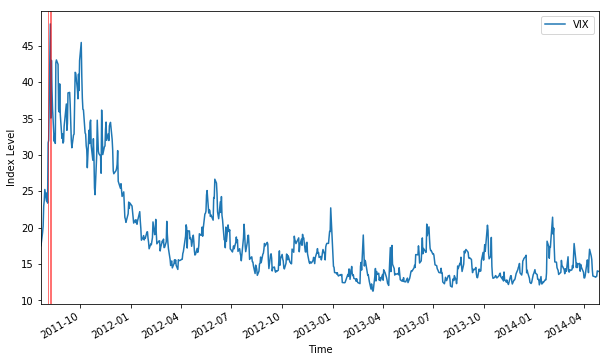

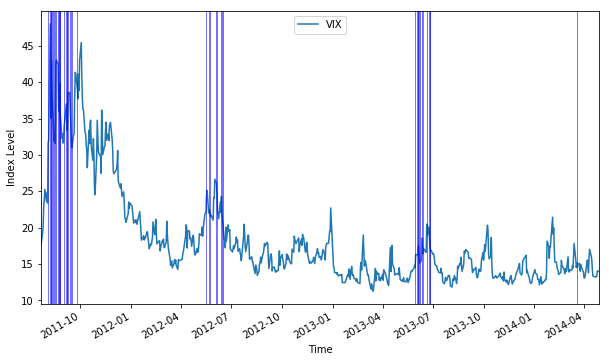

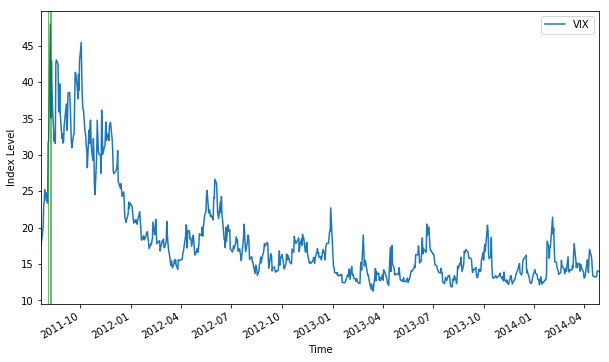

In [31]:
plot_figs(Y_val,labels,vix)


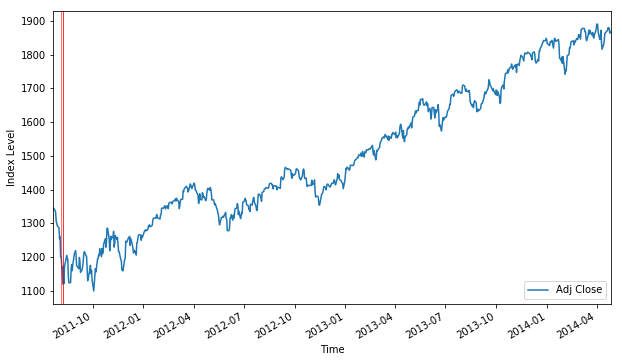

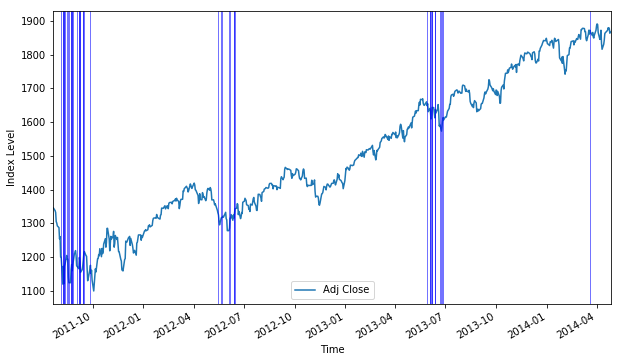

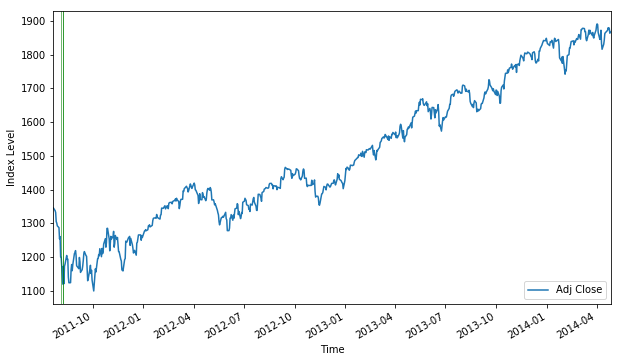

In [32]:
plot_figs(Y_val,labels,security_prices['Adj Close'])


In the above the first plot, vertical lines represent events in the validation set. 

In the second plot, vertical lines represent predicted events

In the third plot, vertical lines represent events both in the predicted and validation set

### While the predicted set certainly overstates the number of events, we can see that it accuractely predicts almost all of them. It seems to even warn us ahead of time of upcoming events, and pick up on spikes that aren't considered events but could be. This appears to be quite promising!

Now lets examine the test set

In [33]:
pred2 = my_model.predict(X_test)
labels2 = proba_to_label(pred2,0.5)
labels2 = labels2.astype(int)
acc = accuracy_score(Y_test,labels2)
f1 = f1_score(Y_test,labels2)
roc = roc_auc_score(Y_test,labels2)
prec = precision_score(Y_test,labels2)
recall= recall_score(Y_test,labels2)

print (' Accuracy: {}'.format(acc))
print (' F1: {}'.format(f1))
print (' RoC: {}'.format(roc))
print (' Precision: {}'.format(prec))
print (' Recall: {}'.format(recall))


 Accuracy: 0.9643268124280783
 F1: 0.16216216216216214
 RoC: 0.7337775202780997
 Precision: 0.0967741935483871
 Recall: 0.5


In [34]:
print (np.where(labels2==1))
print(np.where(Y_test==1))

(array([ 72, 105, 106, 107, 117, 118, 119, 160, 162, 163, 180, 181, 182,
       183, 190, 301, 332, 333, 335, 336, 337, 338, 343, 344, 345, 346,
       449, 450, 451, 452, 601]),)
(array([332, 333, 335, 544, 597, 769]),)


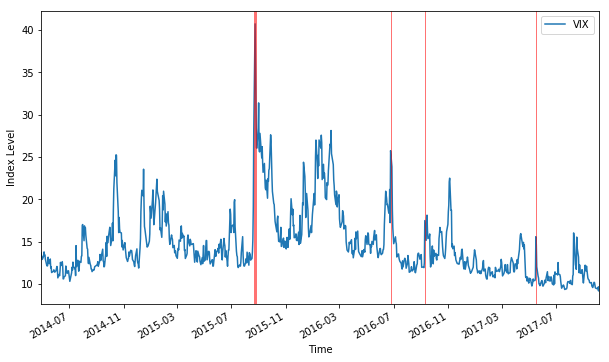

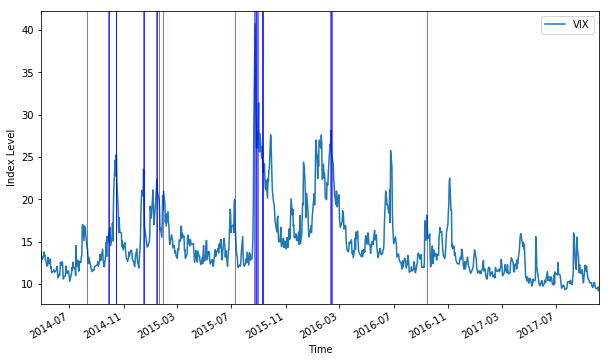

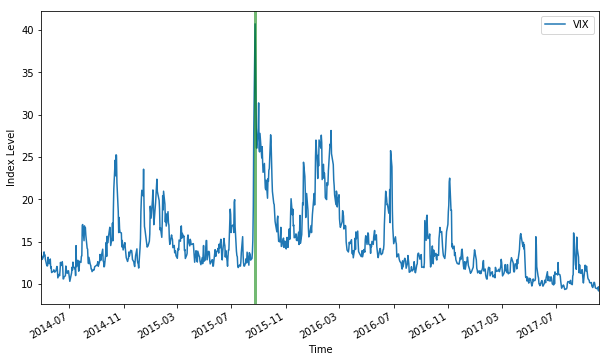

In [35]:
plot_figs(Y_test,labels2,vix)

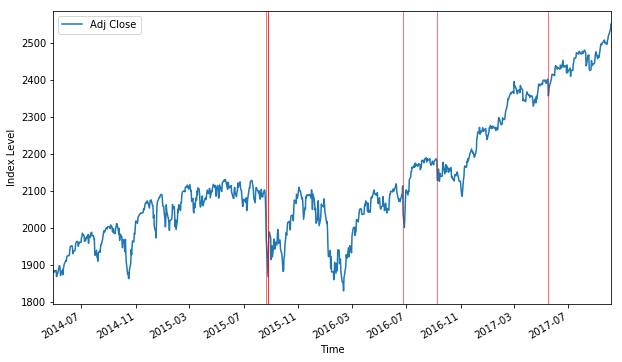

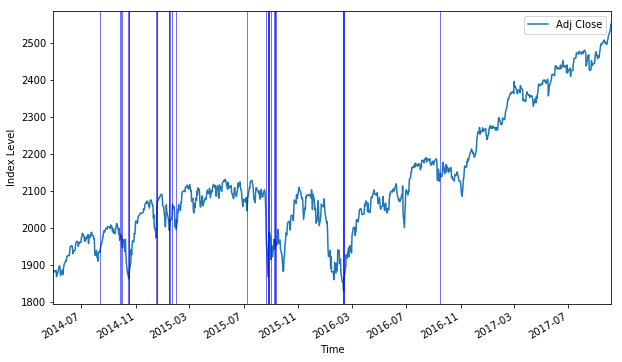

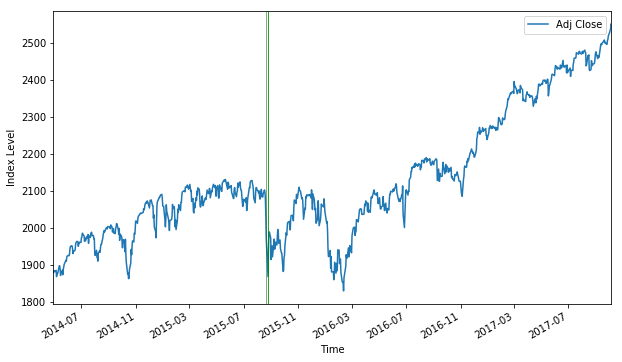

In [36]:
plot_figs(Y_test,labels2,security_prices['Adj Close'])


### As we can see it doesn't exactly find the same events in the test set it finds most of them. The story is the same, when it does recognize an event it signals a little before and a little after they occur. One thing to note is it's unable to find the event in 2017 which occurs in a different volatility regime. So it might be that this event is just too different from the other events. 